# Softmax Regression from Scratch
- Minh Nguyen
- 11/17/2024
- Note
  - Cross-entropy loss is used as it penalizes incorrect predictions more strongly when the confidence is high for the wrong class. It encourages the model to produce high probabilities for the correct class
  - Softmax activate ensure that the predicted value is non-negative and sum to 1
  - `nn.CrossEntropyLoss` combies the softmax acctivation and cross-entropy computation into a single steps
  - Linear layer is a fully connected layer (X * W + b)
  - Logits are the raw, unnormalized scores, produced by the last linear layer of the model, before applying ativation function like softmax or sigmoid. The number in logits can be positive/negative and are not probabilities
  - Why do we use `CrossEntropyLoss` but not init softmax and cross-entropy sepaarately? Numerical stability and efficiency
  - Is there a "Softmax" in regression. No! In regression, the model directly outputs continuous values without using activation function!
    - Softmax is designed for classification problems where the goal is to output a probability distribution over a discrete calss.
  - Do we use exponential or normalization in linear regression? No! In regression, the outputs are directly compared to the target values using the loss function.

Epoch 1/10, Loss: 0.6756
Epoch 2/10, Loss: 0.4948
Epoch 3/10, Loss: 0.4662
Epoch 4/10, Loss: 0.4536
Epoch 5/10, Loss: 0.4399
Epoch 6/10, Loss: 0.4360
Epoch 7/10, Loss: 0.4315
Epoch 8/10, Loss: 0.4273
Epoch 9/10, Loss: 0.4242
Epoch 10/10, Loss: 0.4178
Test Accuracy: 0.8273


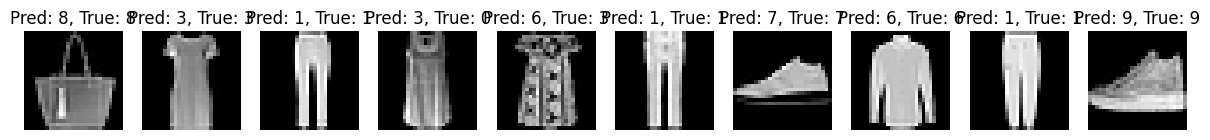

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load and Preprocess dataset
batch_size = 256
num_epochs = 10
learning_rate = 0.1

# Normalize data to improve training
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# Download and load datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Softmax Regression Model
class SoftmaxRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(SoftmaxRegression, self).__init__()
        self.flatten = nn.Flatten()  # Flatten input from (N, 1, 28, 28) to (N, 784)
        self.linear = nn.Linear(num_inputs, num_outputs)  # Linear layer for logits

    def forward(self, X):
        # flatten the input
        X = self.flatten(X)
        logits = self.linear(X)
        return logits # Return the raw scores (logits)
    
# Initialize Model, Loss, Optimizer
num_inputs = 28 * 28
num_outputs = 10

# Model
model = SoftmaxRegression(num_inputs, num_outputs)

# Loss function: Combines softmax activation and cross-entropy loss for numerical stability
loss_fn = nn.CrossEntropyLoss()

# Optimizer: SGD
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Loss Function
def train(model, train_loader, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss, total_samples = 0, 0
        
        for X, y in train_loader:
            # Forward pass
            logits = model(X)
            loss = loss_fn(logits, y)

            # Backward pass
            optimizer.zero_grad()  # Reset gradients
            loss.backward()        # Compute gradients
            optimizer.step()       # Update parameters

            # Track loss
            total_loss += loss.item() * X.size(0)
            total_samples += X.size(0)
        
        avg_loss = total_loss / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    
    with torch.no_grad():  # Disable gradient computation
        for X, y in test_loader:
            logits = model(X)
            predictions = logits.argmax(dim=1)  # Select the class with the highest score
            correct += (predictions == y).sum().item()
            total += y.size(0)
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Train the model
train(model, train_loader, loss_fn, optimizer, num_epochs)

# Evaluate the model
evaluate(model, test_loader)

def visualize_predictions(model, dataset, num_samples=10):
    model.eval()
    indices = torch.randperm(len(dataset))[:num_samples]  # Randomly select samples
    samples = torch.stack([dataset[i][0] for i in indices])  # Images
    labels = [dataset[i][1] for i in indices]  # True labels

    with torch.no_grad():
        logits = model(samples)
        predictions = logits.argmax(dim=1)  # Predicted labels

    # Plot images with predicted and true labels
    plt.figure(figsize=(15, 5))
    for i, (img, pred, true) in enumerate(zip(samples, predictions, labels)):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Pred: {pred.item()}, True: {true}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset)



- Improvement:
  - Regularization: Added weight decay to optimizer to reduce overfit
  - Batch Normalization: Noramlize intermediate activations for faster convergence.
    - Normalizes the input to each layer to have zero mean and unit variance during training.
    - Reduces internal covariate shift, speeding up convergence.
    - Adds a slight computational overhead but significantly improves performance.
  - Learning Rate Schedules: Adjust learning rate during trainnig for better performance
    - StepLR: Reduces the learning rate every few epochs to allow fine-tuning in later epochs.

Epoch 1/10, Loss: 0.5428, LR: 0.100000
Epoch 2/10, Loss: 0.4497, LR: 0.100000
Epoch 3/10, Loss: 0.4348, LR: 0.100000
Epoch 4/10, Loss: 0.4271, LR: 0.100000
Epoch 5/10, Loss: 0.4192, LR: 0.010000
Epoch 6/10, Loss: 0.3963, LR: 0.010000
Epoch 7/10, Loss: 0.3937, LR: 0.010000
Epoch 8/10, Loss: 0.3937, LR: 0.010000
Epoch 9/10, Loss: 0.3911, LR: 0.010000
Epoch 10/10, Loss: 0.3914, LR: 0.001000
Test Accuracy: 0.8448


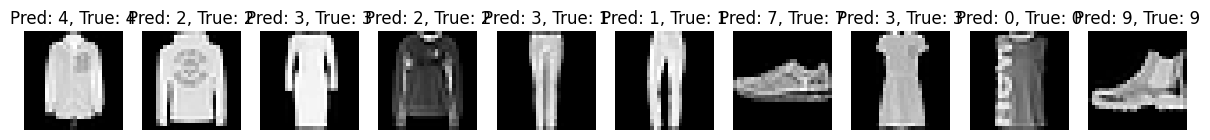

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load and Preprocess dataset
batch_size = 256
num_epochs = 10
learning_rate = 0.1

# Normalize data to improve training
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

# Download and load datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class EnhancedSoftmaxRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(EnhancedSoftmaxRegression, self).__init__()
        self.flatten = nn.Flatten()  # Flatten input from (N, 1, 28, 28) to (N, 784)
        self.linear = nn.Linear(num_inputs, num_outputs)  # Linear layer for logits
        self.bn = nn.BatchNorm1d(num_inputs)  # Batch Normalization for input layer
    
    def forward(self, X):
        X = self.flatten(X)
        X = self.bn(X)  # Apply batch normalization
        logits = self.linear(X)
        return logits
    
# Initialize Model, Loss, Optimizer
num_inputs = 28 * 28
num_outputs = 10

# Model initialization
model = EnhancedSoftmaxRegression(num_inputs, num_outputs)

# Optimizer with weight decay (L2 regularization)
weight_decay = 1e-4  # Regularization strength
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Step learning rate scheduler: Reduce LR every 5 epochs by a factor of 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

def train_with_extensions(model, train_loader, loss_fn, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss, total_samples = 0, 0
        
        for X, y in train_loader:
            # Forward pass
            logits = model(X)
            loss = loss_fn(logits, y)

            # Backward pass
            optimizer.zero_grad()  # Reset gradients
            loss.backward()        # Compute gradients
            optimizer.step()       # Update parameters

            # Track loss
            total_loss += loss.item() * X.size(0)
            total_samples += X.size(0)
        
        # Update the learning rate
        scheduler.step()
        
        avg_loss = total_loss / total_samples
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")


def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    
    with torch.no_grad():  # Disable gradient computation
        for X, y in test_loader:
            logits = model(X)
            predictions = logits.argmax(dim=1)  # Select the class with the highest score
            correct += (predictions == y).sum().item()
            total += y.size(0)
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Train the model with regularization, batch normalization, and LR schedule
train_with_extensions(model, train_loader, loss_fn, optimizer, scheduler, num_epochs)

# Evaluate the model
evaluate(model, test_loader)

def visualize_predictions(model, dataset, num_samples=10):
    model.eval()
    indices = torch.randperm(len(dataset))[:num_samples]  # Randomly select samples
    samples = torch.stack([dataset[i][0] for i in indices])  # Images
    labels = [dataset[i][1] for i in indices]  # True labels

    with torch.no_grad():
        logits = model(samples)
        predictions = logits.argmax(dim=1)  # Predicted labels

    # Plot images with predicted and true labels
    plt.figure(figsize=(15, 5))
    for i, (img, pred, true) in enumerate(zip(samples, predictions, labels)):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Pred: {pred.item()}, True: {true}")
        plt.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset)
